# Distributions of MPP

In [1]:
# 0 - imports
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import palettable as pal
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats

from analysis.utils import load_pre_post_processing, robust_z_score
import analysis.cluster as clu
import analysis.visualizations as vis
from analysis.cox import CoxModel


%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(0)

pathai_colors = {
    "spacecadet":"#2D2849",
    "darkgreen":"#195866",
    "mediumgreen":"#2AA095",
    "violet":"#793EF8",
    "turquoise":"#4CEAD3",
    "raspberry":"#C5304B",
    "darkgray":"#333132",
    "lightgray":"#EEEEEE",
    "lightviolet":"#EBE2FE",
    "lightgreen":"#E1EFED",
    "_darkblue":"#173D52",
    "_lightblue":"#16B2E1",
    "_purple":"#852693",
    "_red":"#E11C29",
}

pathai_cmaps = {key: clr.LinearSegmentedColormap.from_list(key, ['#FFFFFF',pathai_colors[key]], N=256) for key in pathai_colors.keys()}

# cancer, fibroblast, lymphocyte

#BRCA HEX# 6a59a6; LUAD HEX# 3cb76d; PRAD HEX# 343132
palette = ["#6a59a6", "#3cb76d", "#343132"]
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing("../")

Acquiring slide metadata for each dataset.

### Plotting the pixel dimension values for each dataset.

Text(0, 0.5, 'N Slides')

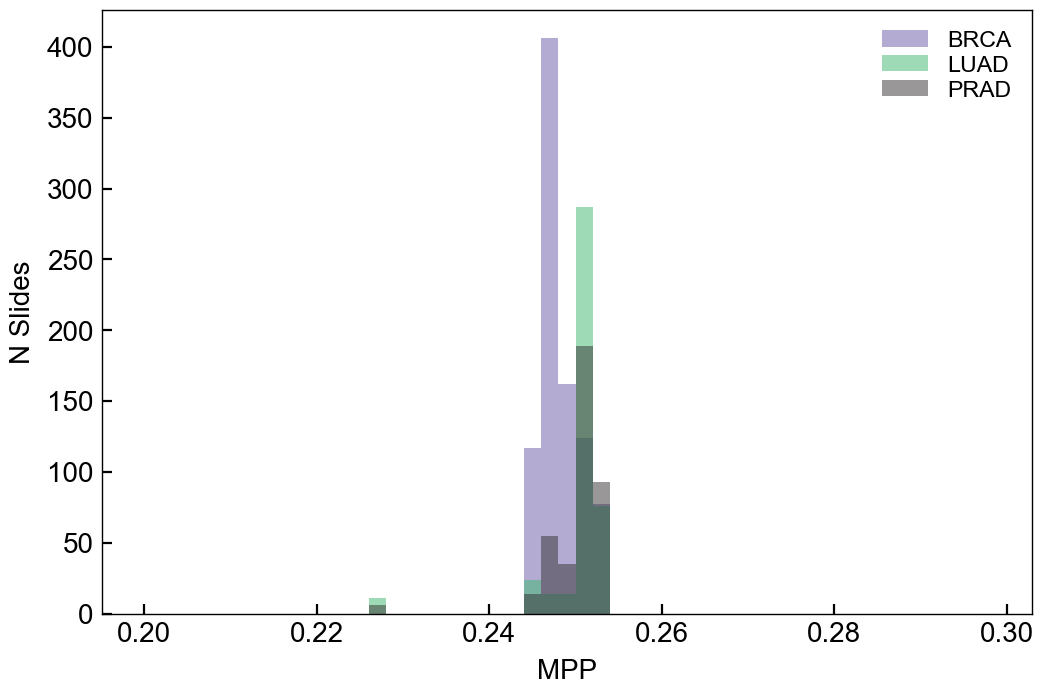

In [3]:
plt.figure()
ax = plt.subplot()
ax.hist(meta_data["brca"]["mpp"].values, bins = np.arange(0.2, 0.3, 0.002), alpha=0.5, color=palette[0], label="BRCA")
ax.hist(meta_data["luad"]["mpp"].values, bins = np.arange(0.2, 0.3, 0.002), alpha=0.5, color=palette[1], label="LUAD")
ax.hist(meta_data["prad"]["mpp"].values, bins = np.arange(0.2, 0.3, 0.002), alpha=0.5, color=palette[2], label="PRAD")
plt.legend()
ax.set_xlabel("MPP")
ax.set_ylabel("N Slides")
#plt.savefig("figures/supp/mpp.svg")

In [4]:
np.median(meta_data["brca"]["mpp"])

0.248

In [5]:
np.median(meta_data["luad"]["mpp"])

0.252

In [6]:
np.median(meta_data["prad"]["mpp"])

0.252

A bit more plotting.

### Association between pixel size and nuclear area for different cell types

In [7]:
def retrieve_xy(subtype, xname, yname, filter_dict=None, celltype="cancer"):
    if celltype=="cancer":
        nuhif_data = cancer_nuhif_data
    elif celltype=="lymphocyte":
        nuhif_data = lymphocyte_nuhif_data
    elif celltype=="fibroblast":
        nuhif_data = fibroblast_nuhif_data
    else:
        assert 1==0
        
    xdf = meta_data[subtype]
    ydf = nuhif_data[subtype]
    
    if filter_dict:
        for key in filter_dict.keys():
            xdf = xdf[xdf[key].isin(filter_dict[key])]
        ydf = ydf.loc[xdf.index]
    
    x = xdf[xname].values
    y = ydf[yname].values
    
    good_vals = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x = x[good_vals]
    y = y[good_vals]
    return x, y
    
def summary_str(name, x, y):
    r, p = stats.pearsonr(x, y)
    if p < 0.001:
        pstr = "p < 0.001"
    else:
        pstr = f"p = {np.round(p, 3)}"

    summary = f"{name}\nr = {np.round(r, 3)}, {pstr}, N = {len(x)}"
    return summary

def plot_pixel_bias(xname, yname, xname_short, yname_short, strx, stry, xlim=None, ylim=None, celltype="cancer"):
    fig, sp = plt.subplot_mosaic(
        """abc""",
        figsize=(8.5,2)
    )
    ax = sp["a"]
    bx = sp["b"]
    cx = sp["c"]
    # dx = sp["d"]

    xb, yb = retrieve_xy("brca", xname, yname, celltype=celltype)
    strb = summary_str("BRCA", xb, yb)
    xl, yl = retrieve_xy("luad", xname, yname, celltype=celltype)
    strl = summary_str("LUAD", xl, yl)
    xp, yp = retrieve_xy("prad", xname, yname, celltype=celltype)
    strp = summary_str("PRAD", xp, yp)

    ax.plot(xb, yb, ls="", marker="o", markersize=1.5, color=palette[0])
    bx.plot(xl, yl, ls="", marker="o", markersize=1.5, color=palette[1])
    cx.plot(xp, yp, ls="", marker="o", markersize=1.5, color=palette[2])

    # strall = summary_str("Pan-Can", np.hstack([xb,xl,xp]), np.hstack([yb,yl,yp]))
    # dx.plot(xb, yb, ls="", marker="o", markersize=1.5, color=palette[0])
    # dx.plot(xp, yp, ls="", marker="o", markersize=1.5, color=palette[2])
    # dx.plot(xl, yl, ls="", marker="o", markersize=1.5, color=palette[1])

    ax.text(strx, stry, strb, fontsize=6)
    bx.text(strx, stry, strl, fontsize=6)
    cx.text(strx, stry, strp, fontsize=6)
    # dx.text(strx, stry, strall, fontsize=6)

    if xlim:
        for xx in [ax, bx, cx]:
            xx.set_xlim(xlim)
            xx.set_xlabel(xname_short)

    if ylim:
        for xx in [ax, bx, cx]:
            xx.set_ylim(ylim)
        ax.set_ylabel(yname_short)
        for xx in [bx, cx]:
            xx.set_yticklabels([])
            
    return fig

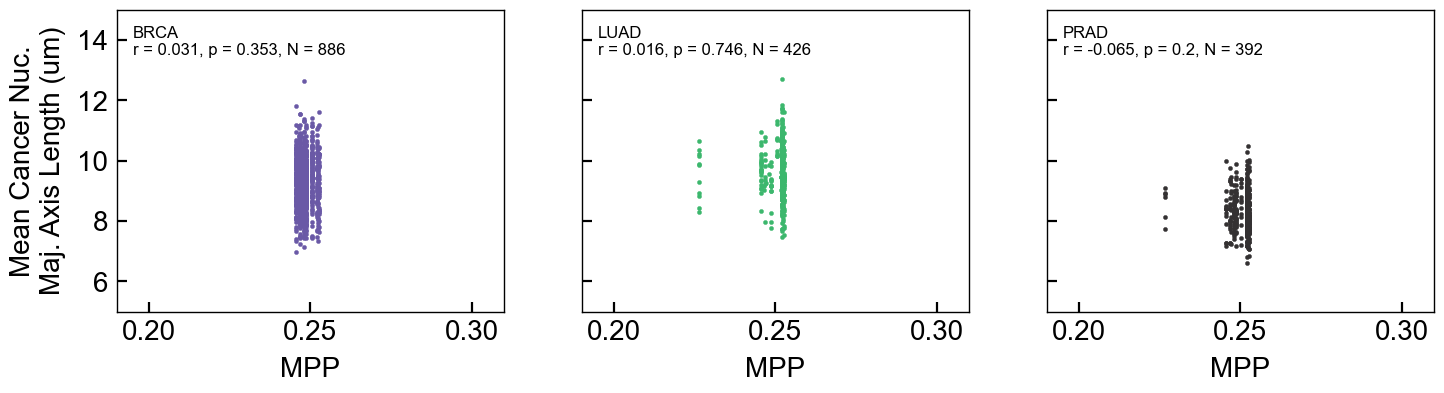

In [8]:
yname = 'MEAN[CANCER CELL_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E'
yname_short = "Mean Cancer Nuc.\nMaj. Axis Length (um)"
xname = "mpp"
xname_short = "MPP"
xlim = [0.19, 0.31]
ylim=[5,15]
strx = 0.195
stry = 13.5

fig = plot_pixel_bias(xname, yname, xname_short, yname_short, strx, stry, xlim=xlim, ylim=ylim)
#plt.savefig("figures/supp/mpp-cancer.svg")

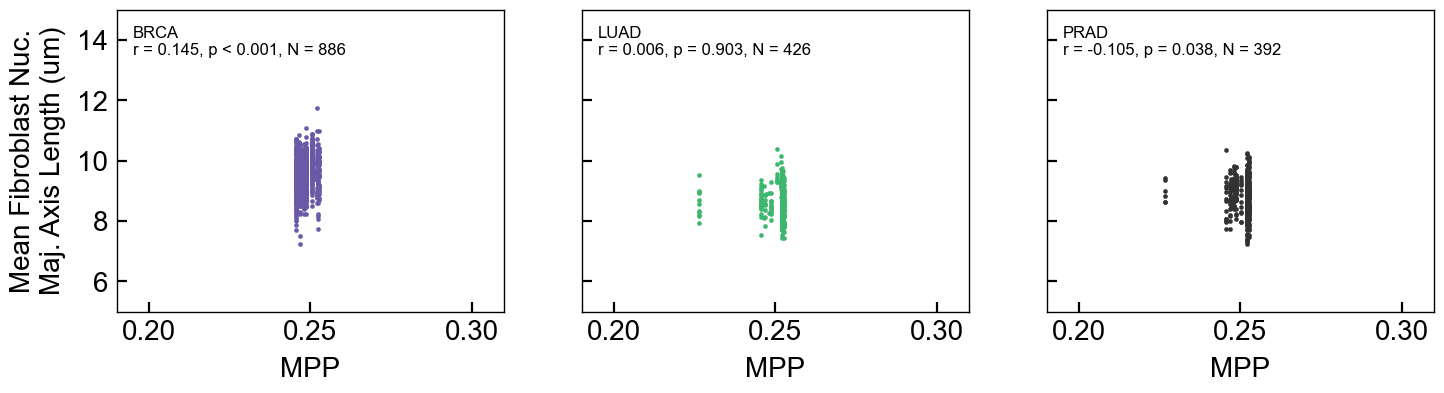

In [9]:
yname = 'MEAN[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E'
yname_short = "Mean Fibroblast Nuc.\nMaj. Axis Length (um)"
xname = "mpp"
xname_short = "MPP"
xlim = [0.19, 0.31]
ylim=[5,15]
strx = 0.195
stry = 13.5

fig = plot_pixel_bias(xname, yname, xname_short, yname_short, strx, stry, xlim=xlim, ylim=ylim, celltype="fibroblast")

# plt.savefig("figures/supp/mpp-fibroblast.svg")

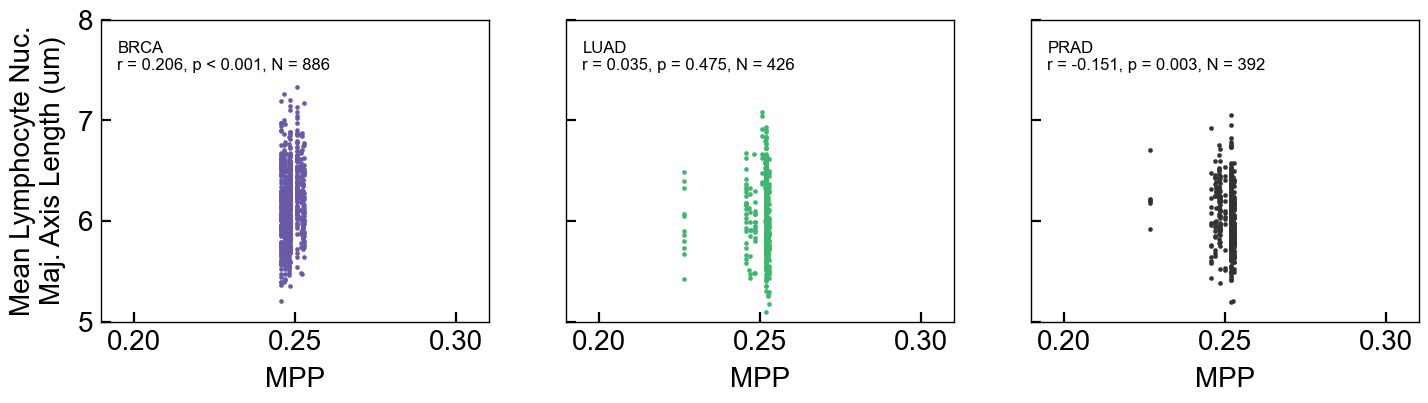

In [10]:
yname = 'MEAN[LYMPHOCYTE_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E'
yname_short = "Mean Lymphocyte Nuc.\nMaj. Axis Length (um)"
xname = "mpp"
xname_short = "MPP"
xlim = [0.19, 0.31]
ylim=[5,8]
strx = 0.195
stry = 7.5

fig = plot_pixel_bias(xname, yname, xname_short, yname_short, strx, stry, xlim=xlim, ylim=ylim, celltype="lymphocyte")

# plt.savefig("figures/supp/mpp-lymphocyte.svg")

### Histograms for a few different feature types

In [11]:
def retrieve_y(subtype, yname, celltype="cancer"):
    if celltype=="cancer":
        nuhif_data = cancer_nuhif_data
    elif celltype=="lymphocyte":
        nuhif_data = lymphocyte_nuhif_data
    elif celltype=="fibroblast":
        nuhif_data = fibroblast_nuhif_data
    else:
        assert 1==0
        
    ydf = nuhif_data[subtype]
    y = ydf[yname].values
    
    good_vals = ~np.isnan(y)
    y = y[good_vals]
    return y


def plot_hists(yname_fcn, yname_short_fcn, xlim=None, ylim=None, blow=0, bhi=40, bd=0.5):
    fig, sp = plt.subplot_mosaic(
        """abc""",
        figsize=(8.5,2)
    )
    ax = sp["a"]
    bx = sp["b"]
    cx = sp["c"]
    # dx = sp["d"]
    
    axes = [ax, bx, cx]
    cell_type_hif = ["CANCER CELL", "FIBROBLAST", "LYMPHOCYTE"]
    for ci, celltype in enumerate(["cancer", "fibroblast", "lymphocyte"]):
        yname = yname_fcn(cell_type_hif[ci])
        print(yname)
        yb = retrieve_y("brca", yname, celltype=celltype)
        yl = retrieve_y("luad", yname, celltype=celltype)
        yp = retrieve_y("prad", yname, celltype=celltype)

        axes[ci].hist(yb, bins=np.arange(blow, bhi, bd), alpha=0.5, color=palette[0], label="BRCA")
        axes[ci].hist(yl, bins=np.arange(blow, bhi, bd), alpha=0.5, color=palette[1], label="LUAD")
        axes[ci].hist(yp, bins=np.arange(blow, bhi, bd), alpha=0.5, color=palette[2], label="PRAD")

    if xlim:
        for xi, xx in enumerate(axes):
            xx.set_xlim(xlim)
            xx.set_xlabel(yname_short_fcn(cell_type_hif[xi].lower().capitalize()))
    ax.set_ylabel("N Slides")
    return fig

MEAN[CANCER CELL_NUCLEUS_AREA]_H & E
MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E
MEAN[LYMPHOCYTE_NUCLEUS_AREA]_H & E


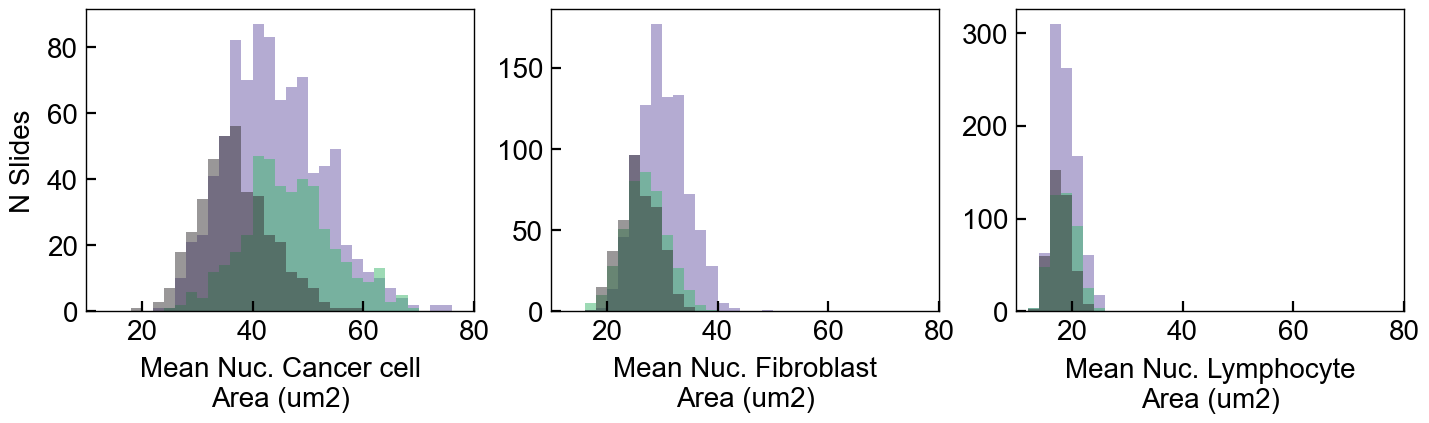

In [12]:
yname_short_fcn = lambda x: f"Mean Nuc. {x}\nArea (um2)"
yname_fcn = lambda x: f"MEAN[{x}_NUCLEUS_AREA]_H & E"
xlim=[10,80]

fig = plot_hists(yname_fcn, yname_short_fcn, xlim=xlim, ylim=None, blow=10, bhi=80, bd=2)
#plt.savefig("figures/supp/dist-area.svg")

MEAN[CANCER CELL_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E
MEAN[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E
MEAN[LYMPHOCYTE_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E


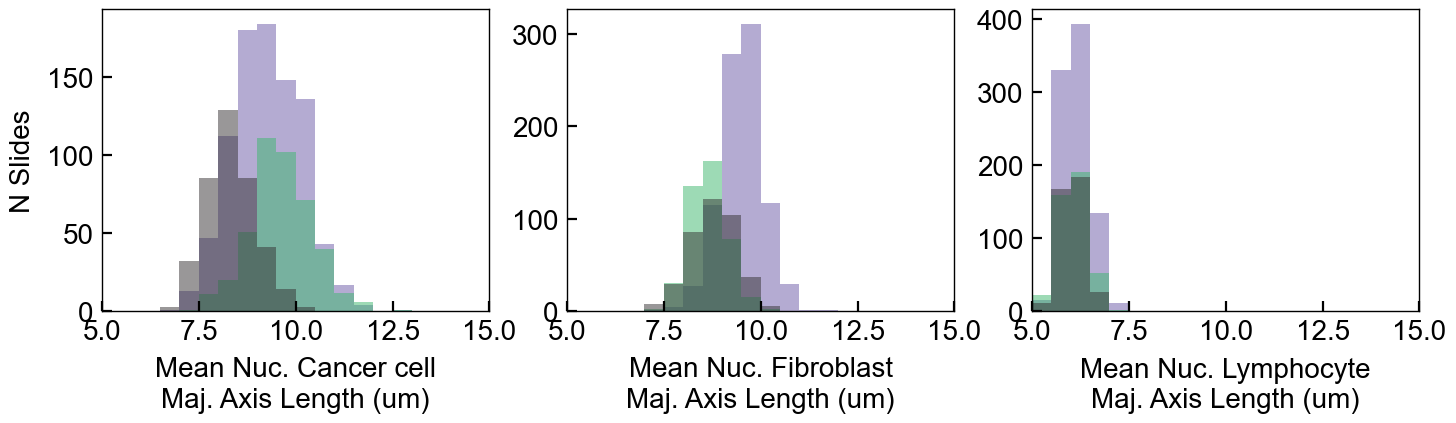

In [13]:
yname_short_fcn = lambda x: f"Mean Nuc. {x}\nMaj. Axis Length (um)"
yname_fcn = lambda x: f"MEAN[{x}_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E"
xlim=[5,15]

fig = plot_hists(yname_fcn, yname_short_fcn, xlim=xlim, ylim=None, blow=5, bhi=15, bd=0.5)
#plt.savefig("figures/supp/dist-maj.svg")

MEAN[CANCER CELL_NUCLEUS_MINOR_AXIS_LENGTH]_H & E
MEAN[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E
MEAN[LYMPHOCYTE_NUCLEUS_MINOR_AXIS_LENGTH]_H & E


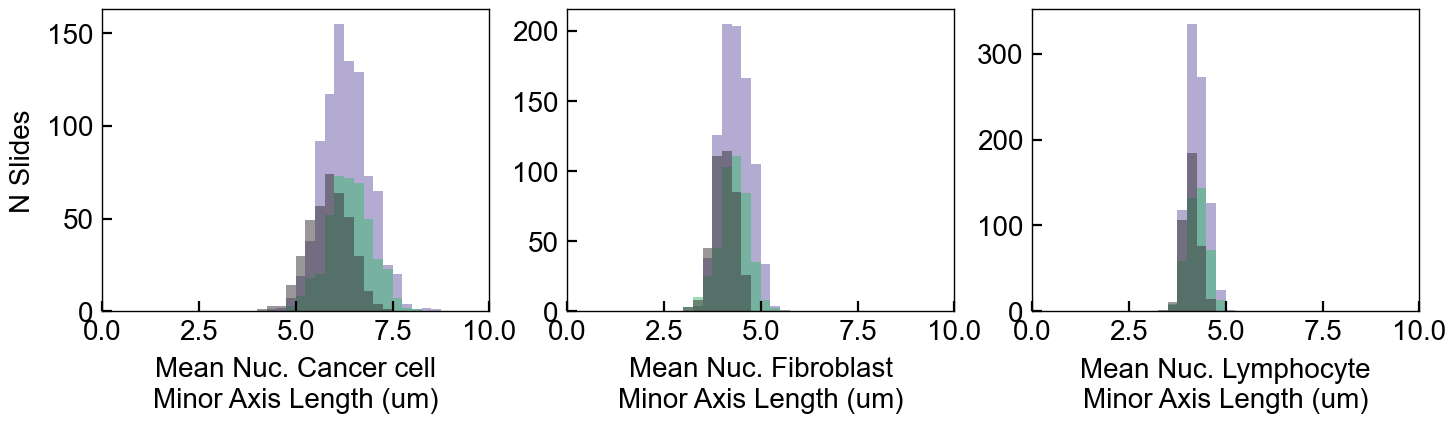

In [14]:
yname_short_fcn = lambda x: f"Mean Nuc. {x}\nMinor Axis Length (um)"
yname_fcn = lambda x: f"MEAN[{x}_NUCLEUS_MINOR_AXIS_LENGTH]_H & E"
xlim=[0,10]

fig = plot_hists(yname_fcn, yname_short_fcn, xlim=xlim, ylim=None, blow=0, bhi=10, bd=0.25)
#plt.savefig("figures/supp/dist-min.svg")